# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [256]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport stopping_power_ml
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
from tqdm import tqdm_notebook as tqdm

from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle as pkl
import numpy as np
import pandas as pd
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in Data
Read in data from all velocities

In [242]:
import gzip

data = pkl.load(gzip.open('../training_data.pkl.gz', 'rb'))

## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

Text(0,0.5,'Force')

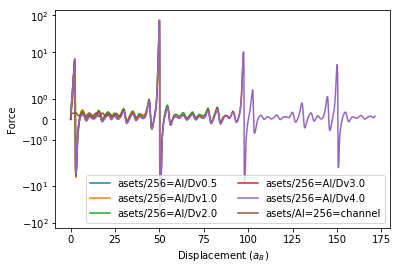

In [243]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
ax.set_yscale('symlog')
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Text(0,0.5,'Force')

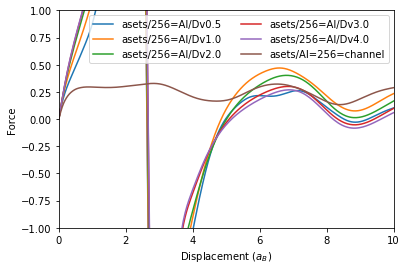

In [244]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)

ax.set_xlim(0, 10)

ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

In [245]:
set(data['directory'])

{'datasets/256_Al/Dv0.5',
 'datasets/256_Al/Dv1.0',
 'datasets/256_Al/Dv2.0',
 'datasets/256_Al/Dv3.0',
 'datasets/256_Al/Dv4.0',
 'datasets/Al_256_channel'}

Andre uses 6 $a_B$

In [246]:
data.query('displacement >= 6', inplace=True)
data.query("directory != 'datasets/Al_256_channel'", inplace=True)

## Generate Features
Use the same features at the Al model

In [247]:
featurizers = pkl.load(open('../featurizers.pkl', 'rb'))

In [248]:
'''
%%time
for f in featurizers:
    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)
'''

"\n%%time\nfor f in featurizers:\n    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)\n"

In [285]:
data['v0'] = [ v[0] for v in data['velocity'] ]
data['v1'] = [ v[1] for v in data['velocity'] ]
data['v2'] = [ v[2] for v in data['velocity'] ]

In [286]:
X_cols = sum([f.feature_labels() for f in featurizers.featurizers], [])
X_cols += ['v0','v1','v2']
y_col = 'force'

In [287]:
#data['velocity_mag'] = data['velocity'].apply(np.linalg.norm)

In [288]:
#X_cols += ['velocity_mag',]

In [291]:
print('Features: {}'.format(len(X_cols)))
X_cols


Features: 21


['charge density at t=-4.00',
 'charge density at t=-3.00',
 'charge density at t=-2.00',
 'charge density at t=-1.00',
 'charge density at t=-0.50',
 'charge density at t=0.00',
 'charge density at t=0.50',
 'charge density at t=1.00',
 'charge density at t=2.00',
 'AGNI projected eta=8.00e-01',
 'AGNI projected eta=1.23e+00',
 'AGNI projected eta=1.88e+00',
 'AGNI projected eta=2.89e+00',
 'AGNI projected eta=4.43e+00',
 'AGNI projected eta=6.80e+00',
 'AGNI projected eta=1.04e+01',
 'AGNI projected eta=1.60e+01',
 'ion-ion repulsion',
 'v0',
 'v1',
 'v2']

In [252]:
'''
for i in range(-2, 2):
    if i != 0:
        a = 'velocity_mag_exp=%i'%i
        data[a] = np.exp(i * data['velocity_mag'])
        X_cols += [a,]
'''

## Fit on Entire Dataset
Use the Bayesian Ridge Regression model from previous examples. 

In [274]:
def fit_on_whole_dataset(model, callbacks=[], epochs=1):

    try:
        model.fit(data[X_cols], data[y_col], epochs=epochs, callbacks=callbacks)
    except Exception as e:
        print(e)
        model.fit(data[X_cols], data[y_col])

    data['force_fit'] = model.predict(data[X_cols])

    fig, ax = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        velocity.append(float(gid[-3:]))
        
        # Plot the performance
        my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

        ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)
        
        ax[0].set_xlim(30, 40)
        ax[0].set_ylim(-0.3, 0.7)
        ax[0].legend(ncol=2)

        ax[0].set_xlabel('Displacement (a.u.)')
        ax[0].set_ylabel('Force ($E_H / a_B$)')
        
        # Plot the mean velocity
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[1].set_xlabel('Velocity (au.)')
    ax[1].set_ylim(0, max(ax[1].get_ylim()))
    ax[1].set_xlim(0, 4.2)
    ax[1].legend()
    
    fig.tight_layout()
    
    return fig, ax

In [275]:
def build_dense_model(layers, input_shape, activation, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential()
    model.add(Dense(layers[0], input_shape=input_shape, activation=activation))
    for layer in layers[1:]:
        model.add(Dense(layer, activation=activation))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    return model

Epoch 1/100
46349/46349 [==============================] - 4s 87us/step - loss: 0.1570 - mean_absolute_error: 0.1570
Epoch 2/100
46349/46349 [==============================] - 3s 67us/step - loss: 0.0550 - mean_absolute_error: 0.0550
Epoch 3/100
46349/46349 [==============================] - 3s 66us/step - loss: 0.0437 - mean_absolute_error: 0.0437
Epoch 4/100
46349/46349 [==============================] - 3s 71us/step - loss: 0.0382 - mean_absolute_error: 0.0382
Epoch 5/100
46349/46349 [==============================] - 3s 69us/step - loss: 0.0358 - mean_absolute_error: 0.0358
Epoch 6/100
46349/46349 [==============================] - 3s 71us/step - loss: 0.0336 - mean_absolute_error: 0.0336
Epoch 7/100
46349/46349 [==============================] - 3s 67us/step - loss: 0.0313 - mean_absolute_error: 0.0313
Epoch 8/100
46349/46349 [==============================] - 3s 71us/step - loss: 0.0327 - mean_absolute_error: 0.0327
Epoch 9/100
46349/46349 [==============================] - 3s 70

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe713744ef0>,
       dtype=object))

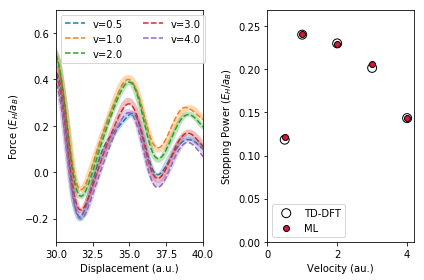

In [292]:
input_shape = (21,)
layers = (input_shape[0],16,8,4)
activation = 'relu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 100

callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto')]

fit_on_whole_dataset( build_dense_model(layers, input_shape, activation), callbacks=callbacks, epochs=epochs )

You'll note the model predictions (thick, translucent lines) <del>do not really differ based on velocity, and nor do the predicted stopping powers</del>

In [ ]:
fig, ax = fit_on_whole_dataset( build_dense_model(layers, input_shape, activation), callbacks=callbacks, epochs=epochs )

fig.savefig('figures/Al_all_velocities.png', dpi=320)
fig.savefig('figures/Al_all_velocities.pdf')

Epoch 1/100
46349/46349 [==============================] - 4s 81us/step - loss: 0.1560 - mean_absolute_error: 0.1560
Epoch 2/100
46349/46349 [==============================] - 3s 72us/step - loss: 0.0480 - mean_absolute_error: 0.0480
Epoch 3/100
46349/46349 [==============================] - 3s 70us/step - loss: 0.0354 - mean_absolute_error: 0.0354
Epoch 4/100
46349/46349 [==============================] - 3s 72us/step - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 5/100
46349/46349 [==============================] - 3s 71us/step - loss: 0.0314 - mean_absolute_error: 0.0314
Epoch 6/100
46349/46349 [==============================] - 3s 74us/step - loss: 0.0301 - mean_absolute_error: 0.0301
Epoch 7/100
46349/46349 [==============================] - 3s 74us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 8/100
46349/46349 [==============================] - 3s 72us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 9/100
46349/46349 [==============================] - 3s 69

The predictions do change with the velocities √